# Time Series Forecasting of Historical GME Data

[Daily GME Historical Dataset](https://www.kaggle.com/hananxx/gamestop-historical-stock-prices)

In [64]:
# Below loads all the preliminaries for the analysis.

# Data Manipulation/Plotting

from math import sqrt
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import simplefilter


# statsmodel for statistical modelling (Exponential Smoothing, Seasonal Decomposition, Dickey Fuller Test - ACF/PACF, ADF Test)

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt   

# Sci-kit learn (and Sktime) for metrics, splitting datasets, converting time series to supervised learning
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)

from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)

from sktime.utils.plotting import plot_series


## Data Preprocessing

Setting the index_col parameter to zero and parsing the dates in the column ensures that the data can be considered time series.

In [65]:
data = pd.read_csv(r'D:\Documents\gamestop.csv', index_col=0, parse_dates=['date'])
data.sort_values(by='date', ascending='True')

,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,
2002-02-13,9.625000,10.060000,9.525000,10.050000,19054000.0,6.766666
2002-02-14,10.175000,10.195000,9.925000,10.000000,2755400.0,6.733003
2002-02-15,10.000000,10.025000,9.850000,9.950000,2097400.0,6.699336
2002-02-19,9.900000,9.900000,9.375000,9.550000,1852600.0,6.430017
2002-02-20,9.600000,9.875000,9.525000,9.875000,1723200.0,6.648838
...,...,...,...,...,...,...
2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002
2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996


Python now recognises this dataset as data recorded over a period of time.

In [66]:
ts = data
ts = ts.sort_index() #Sorts to ascending by default
ts = ts[725:4000]
ts = ts.asfreq('M')
ts['adjclose_price'].interpolate(method='linear', inplace=True)

The dataset frequency has been changed from daily frequency to monthly frequency. This technique in data science is known as downsampling, and it's purpose is to reduce your sample size for analysis. Because the dataset is spread over the span of 19 years, predicting based on individual days is unnecessary for capturing the overall structure of the data. Graphs become difficult to read, and a larger quantity of computational processing power is required. Thus, monthly frequency is better suited for this analysis.

To account for the loss of data when converting from daily data to monthly data, [linear interpolation](https://www.toppr.com/guides/maths-formulas/linear-interpolation-formula/) was used to fill the missing data.

The chosen variable for the time series was the close price of GME stocks. In the stock market, close prices * finish *

In [67]:
ts = ts['adjclose_price'] #Select close price as the Series data

In [68]:
ts.describe()

count    157.000000
mean      20.652867
std        7.949016
min        6.426650
25%       14.819336
50%       18.149456
75%       26.757256
max       41.818676
Name: adjclose_price, dtype: float64

Standard deviation measure is low, which means that values in the dataset are not very spread out. This makes sense for time series because values will gradually change over time, so they will be closer together. 

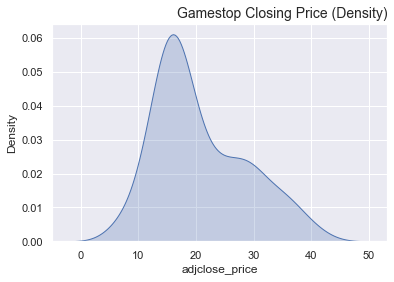

In [69]:
sns.set_style('darkgrid')
sns.kdeplot(ts, shade=True)
plt.title('Gamestop Closing Price (Density)', loc = 'right', fontsize=14)

plt.show()

Density appears to suggest a continuous probability distribution in the form of gamma distribution. For values that can potentially take on a wide range of values, gamma type distribution is likely. For example, [rainfall rates, queue wait times or life expectancy](https://study.com/academy/lesson/gamma-distribution-definition-equations-examples.html) can expect to see gamma type distribution.  

For time series forecasting, as the forecast progresses, elements of the series can take on a wide range of values. This distribution seems appropriate.

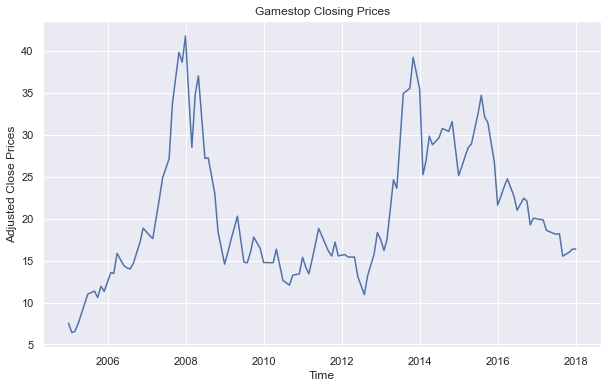

In [70]:
#line graph of closing price, allows for evaluation of seasonality/trend 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Adjusted Close Prices')
plt.plot(ts)
plt.title('Gamestop Closing Prices')
plt.show()


Beginning in 2006, the series measures with low closing prices, gradually increasing, and then peaking in 2008 before plummeting in 2009. Two years later, this same pattern repeats itself from 2011 to 2014. In the fourth quarter of 2015, the trend declines, echoing the same decline as 2009. 


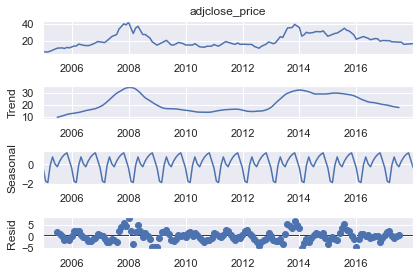

In [71]:
decomp = seasonal_decompose(ts)

decomp.plot()
plt.show()

**Seasonal Decomposition**

Seasonal decomposition describes the mathematical process of converting a single time series into multiple time series. Through this process, underlying features of the time series can be further evaluated:

Trend - Ascending and declining trend is present in this dataset. The trend decline from 2009 to 2014 appears to be steeper than the more gradual decline occuring from 2014 onwards. The peak close price for GME occurred in 2008, with a similar but slightly lower peak occuring in 2014.

Seasonality - In this dataset, the regular peaks that follow a consistent pattern, (2006-2009) and (2011-2014), imply that there is seasonality within this dataset. The decomposition plot appears to show additive seasonality, as indicated by the lack of variation in the patterns as time progresses.

## Statistical Methods for Time Series Forecasting

### Single Exponential Smoothing: 

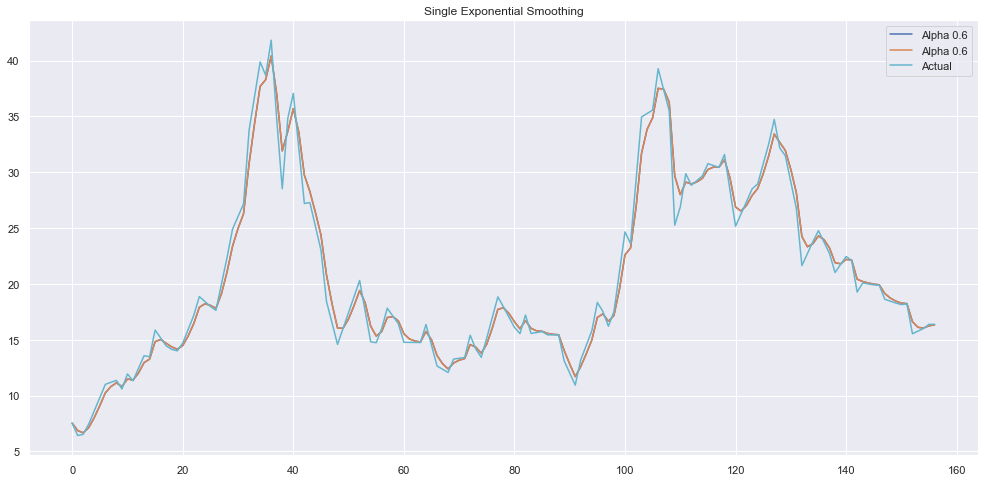

In [72]:
# Sourced from: https://gist.github.com/marcopeix/a9a37792661b57e581414735824e9e9d

def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title('Single Exponential Smoothing')
    plt.grid(True);

plot_exponential_smoothing(ts, [0.6, 0.6])

The alpha parameter functions as the smoothing factor. It decides roughly how well fitted the alpha line will fit to the line plotting the actual data. The higher the alpha parameter is tuned, the more stricter the fit of the alpha line is to the actual line. As shown above, at any alpha measurement, the SES method is incapable capturing the sharpest peaks and troughs in the dataset.

### Double Exponential Smoothing (Holt's Method): 

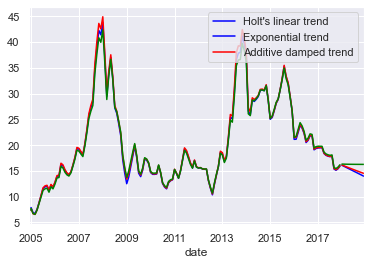

In [73]:
# Sourced from: https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

fit1 = Holt(ts, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

fit2 = Holt(ts, exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast2 = fit2.forecast(12).rename("Exponential trend")

fit3 = Holt(ts, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast3 = fit3.forecast(12).rename("Additive damped trend")

fit1.fittedvalues.plot(color='blue')
fcast1.plot(color='blue', legend=True)

fit2.fittedvalues.plot(color='red')
fcast2.plot(color='red', legend=True)

fit3.fittedvalues.plot(color='green')
fcast3.plot(color='green', legend=True)

plt.show()

Now, the beta parameters are incorporated into the exponential smoothing process, resulting in Double Exponential Smoothing. While the alpha parameters (indicated by the 'smoothing_level' parameter) are maintained for the smoothing factor, the beta parameter (indicated by the 'smoothing_trend' parameter) introduces smoothing for trends in the time series data. As shown by the plot, this allows for more accurate fitting across sharp peaks and troughs. 

### Triple Exponential Smoothing (Holt's-Winter Method)

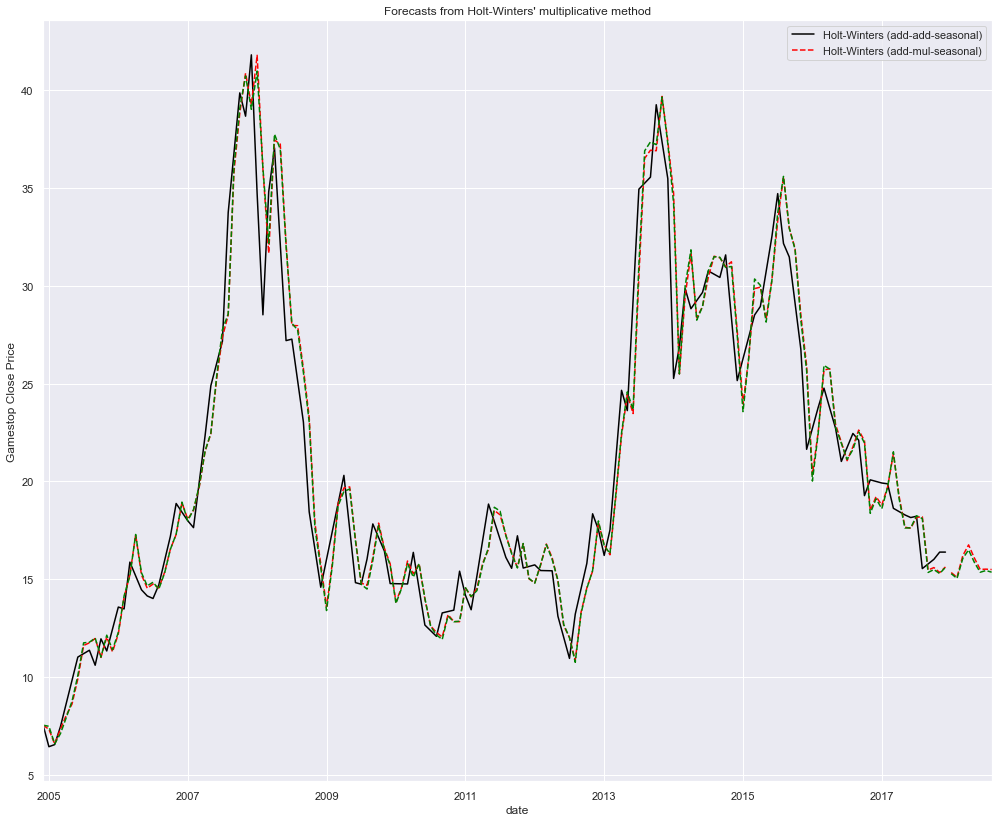


Results: 



,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
$\beta$,5.110087e-02,6.920899e-02,1.702578e-01,1.752018e-01
$\phi$,NaN,NaN,8.000000e-01,8.000000e-01
$\gamma$,1.339219e-08,1.299833e-08,1.279839e-08,1.373222e-08
$l_0$,2.286091e+00,2.317896e+00,2.316701e+00,2.300313e+00
$b_0$,3.921931e-02,4.761333e-02,1.265865e-02,1.685632e-02
SSE,6.719071e+02,6.387095e+02,6.175827e+02,5.881494e+02


In [74]:
fit1 = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = ts.plot(figsize=(17, 14), marker='', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Gamestop Close Price")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.forecast(8).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='', color='red', legend=True)
fit2.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='', color='green', legend=True)

plt.show()
print("\nResults: \n")
results

Triple Exponential Seasoning introduces the gamma parameter to the technique. This parameter allows for fitting to time series data with seasonality present within it's structure. The statsmodel library enables users to use the most optimised parameters for fitting the trend and seasonality lines, as determined by the library. Judging by the plot, the addition/multiplicative seasonality smoothing does not seem to be as accurate as Double Exponential Smoothing for model fitting. The additive/additive method appears to be more suitable for model fitting as the line closely matches the line representing the time series value.

However, for forecasting, both methods appear to look questionable compared to Double Exponential Smoothing. Here, we can conclude that for a quick predicitive fitting for this particular time series, Double Exponential Smoothing performs the best for both fitting and forecasting.

### Naive Forecaster:

The naive forecaster one of the most simplest forecasting methods. It provides a good baseline of comparison for more complex models utilised in the notebook. By setting the size of the test data to 12, the naive forecasting strategy uses this test data to predict the last 12 values of the dataset.

In [75]:
y_train, y_test = temporal_train_test_split(ts, test_size=12)
print(y_train.shape[0], y_test.shape[0])

145 12


In [76]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

Mean Absolute Error:  4.398654023806254

Root Mean Squared Error:  4.604463314539677

Mean Absolute Percentage Error:  22.23325213379622 



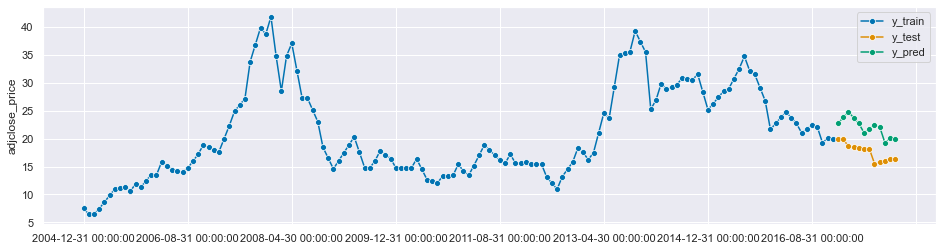

In [77]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print("Mean Absolute Error: ", mean_absolute_error(y_pred, y_test))    
print("\nRoot Mean Squared Error: ", sqrt(mean_squared_error(y_pred, y_test)))
print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(y_pred, y_test)*100, "\n")

For the naive forecaster, the dataset was split into training and testing data. For the Sktime library, a forecasting horizon is required for forecasting. The forecasting horizon functions as the independent 'time' variable which the dependent (y) variable is measured against. In our model, the forecasting horizon uses the index of the test data, because this is what we will be testing our forecasting prediction against. In the plot, both the yellow and green line are tested against each other for accuracy. They have the same amount of points. 

The error metric for this model and all models in this analysis will be the mean absolute error, mean absolute percentage error and root mean squared error. As we can see, the MAE measures at 4.3 and the MAPE is measuring at 22%, which indicates a decently fitted model. The average difference between the test values and the predicted values do not measure more than 25%. Furthermore, the average distance from the test values compared to the predicted values is shown by the RMSE, measuring at 4.6. Because accuracy is in the best interest of this analysis, this low average is a very good score for this analysis.

In the analysis, the objective will be to achieve a model that rivals or outperforms this model by scoring lower metrics than the naive forecaster.

---------------------------------------------------

### AutoRegressive (AR) Model

The Augmented Dickey-Fuller Test is a statistical test used for evaluating whether stationarity is present within time series data. This is crucial for any Autoregressive model (AR). The purpose of the test is to determine whether time series is stationary or not. Below, the regular time series values and the differenced time series values are used for the statistical test.

In [79]:
adf_result=adfuller(ts.values, autolag='AIC')
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],adf_result)) # The names of every value have been added
#tsplot(data_diff.values[1:], lags=12)

{'adf': -2.7085242774945435,
 'pvalue': 0.07257477678593521,
 'usedlag': 4,
 'nobs': 152,
 'criticalvalues': {'1%': -3.474120870218417,
  '5%': -2.880749791423677,
  '10%': -2.5770126333102494},
 'icbest': 633.7057414639812}

In [82]:
adf_result=adfuller(ts_diff.values, autolag='AIC')
#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],adf_result))
#tsplot(data_diff.values[1:], lags=12)

{'adf': -4.039339437051821,
 'pvalue': 0.001217963895551515,
 'usedlag': 13,
 'nobs': 141,
 'criticalvalues': {'1%': -3.4776006742422374,
  '5%': -2.882265832283648,
  '10%': -2.5778219289774156},
 'icbest': 641.7264286092791}

**ADF Statistic: Non-Differenced = -2.708 // Differenced = -4.039**

The more negative this statistic, the more likely the time series can be considered stationary. A value of -2 for the non-differenced time series indicates a decently strong presence of stationarity. However, with differencing, the statistic falls to -4.039 which suggests an even stronger presence of stationarity in the differenced data. 

**P-value: Non-Differenced = 0.07257 // Differenced = 0.001**

The non-differenced values fall slightly higher than the statistical significance metric (0.05). This is an indication that we cannot reject the null hypothesis therefore, even if the ADF statistic is negative, we cannot reject the null hypothesis and must assume the data is non-stationary. For the differenced dataset, the p-value falls extremely low with a difference of 1 between the original values and the lagged values. For this value, we can most certainly reject the null hypothesis, which means we can consider the time series stationary. 

---

#### Non-Differenced Values

#### Non-Stationary Autocorrelation Plot:

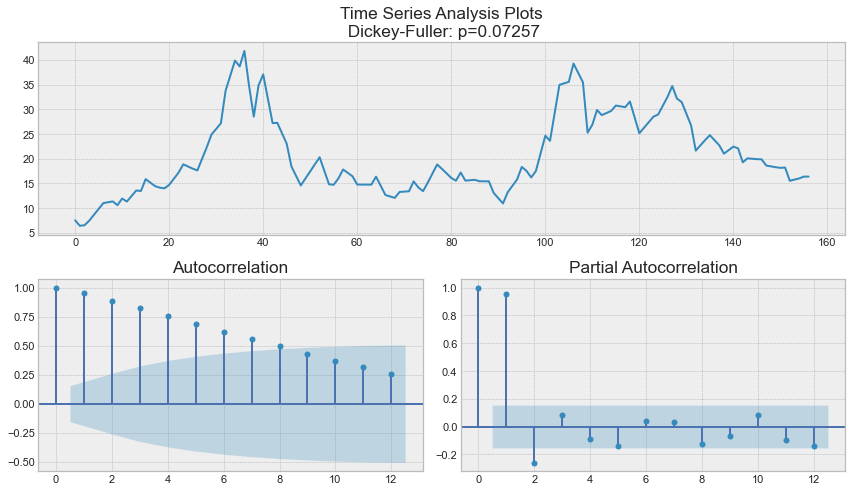

In [78]:
# plots normal time series for Dickey-Fuller Test. Sourced from: 

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = pl.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

# lags parameter determines the amount of points to plot for Autocorrelation plots
tsplot(ts.values, lags=12)

The autocorrelation plot shows the lag values along the X-axis, and the correlation along the Y-axis. The plot shows a declining trend of correlation within the dataset. There are 13 lags present. The first lag is actually lag 0, which corresponds to correlation with itself. For this reason, it is measured as 1. The remaining lags indicate the correlation between the values of the time series dataset with a delayed value of itself. For example, correlation measured at lag 2, measures values of the time series that have shifted by 2. In this case, because the frequency is months, it would shift by a lag value of 2 months.

There is huge amount of significant correlation along all lag values in the plot and the decline is very gradual. It is not until lag 9 that we see a significant decrease in correlation in the ACF plot, as this is the first lag to fall below the statistical signifance boundary (blue shade). 

predicted=25.353518, expected=26.274093
predicted=25.935382, expected=27.392350
predicted=27.601423, expected=28.510607
predicted=27.587224, expected=28.946220
predicted=27.664085, expected=30.738747
predicted=30.956316, expected=32.531273
predicted=32.111614, expected=34.719707
predicted=33.516383, expected=32.167797
predicted=30.988170, expected=31.477779
predicted=31.450423, expected=29.117517
predicted=27.398083, expected=26.757256
predicted=25.378495, expected=21.640425
predicted=20.089539, expected=22.713183
predicted=23.281094, expected=23.785942
predicted=22.724439, expected=24.768423
predicted=23.774111, expected=23.741934
predicted=23.314452, expected=22.715445
predicted=22.597137, expected=21.019987
predicted=19.695702, expected=21.735678
predicted=21.599118, expected=22.451368
predicted=22.559136, expected=22.107035
predicted=21.225289, expected=19.270538
predicted=18.021326, expected=20.078743
predicted=20.686883, expected=19.997419
predicted=19.733032, expected=19.916096


C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


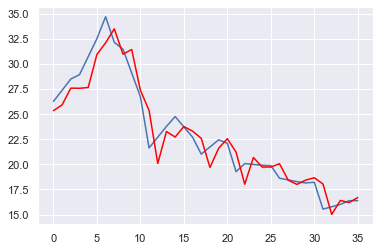

In [80]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

X = ts.values
ar_train, ar_test = X[0:120], X[121:157]
# train autoregression
window = 12
model = AutoReg(ar_train, lags=12)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = ar_train[len(ar_train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(ar_test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = ar_test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
print("\nMean Absolute Error: ", mean_absolute_error(predictions, ar_test))    
print("\nRoot Mean Squared Error: ", sqrt(mean_squared_error(predictions, ar_test)))
print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(predictions, ar_test)*100, "\n")
# plot
plt.plot(ar_test)
plt.plot(predictions, color='red')
plt.show()

#### Differenced Values

#### Stationary Autocorrelation Plot:

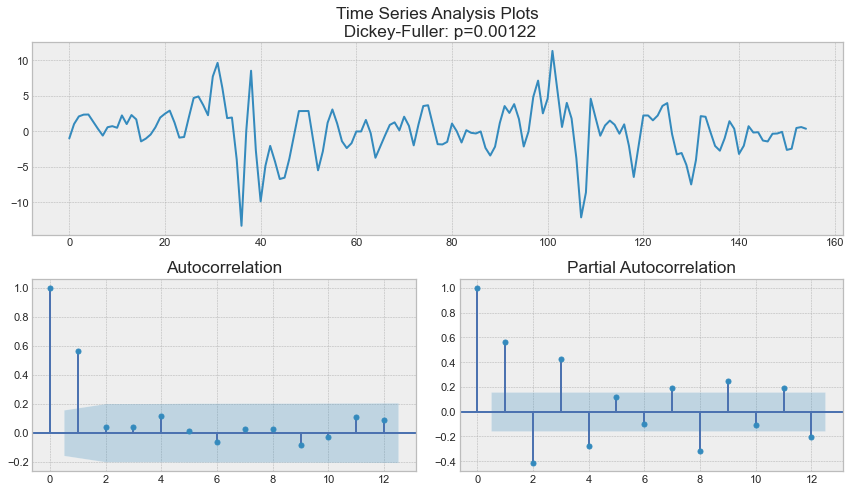

In [81]:
# Augmented Dickey-Fuller Test

ts_diff = ts.diff(2) # Difference data by two
ts_diff = ts_diff.dropna()

# plots normal time series for Dickey-Fuller Test
tsplot(ts_diff.values, lags=12)

Differencing the data by 2 results in the lowest p-value that is > 0. As shown in the ACF plot, most of the points are now within the same blue area, and are measuring close to 0.0. This means that the trend from the data has been removed. As mentioned, lag 0 will always measure at 1. The following lags show heavily decreased correlation with the differenced values in comparison to the non-differenced values. In comparison, these values lose correlation instantly after lag 1, and it is only lag 0 & 1 that are statistically significant because it ranks higher than the significance level (indicated by the blue shade) 

predicted=2.895156, expected=2.236514
predicted=1.182367, expected=1.553871
predicted=-0.571033, expected=2.228140
predicted=2.898261, expected=3.585052
predicted=2.516826, expected=3.980961
predicted=1.835467, expected=-0.363476
predicted=-2.362285, expected=-3.241928
predicted=0.000600, expected=-3.050280
predicted=-2.555447, expected=-4.720524
predicted=-3.700809, expected=-7.477093
predicted=-5.433896, expected=-4.044072
predicted=1.431417, expected=2.145517
predicted=1.543035, expected=2.055240
predicted=-0.595392, expected=-0.044008
predicted=0.432693, expected=-2.052979
predicted=-1.670327, expected=-2.721947
predicted=-1.228912, expected=-0.979767
predicted=-0.127479, expected=1.431381
predicted=2.578081, expected=0.371357
predicted=-1.560783, expected=-3.180830
predicted=-2.769662, expected=-2.028292
predicted=0.692165, expected=0.726881
predicted=0.995860, expected=-0.162647
predicted=-0.760324, expected=-0.121983
predicted=0.923395, expected=-1.294624
predicted=-1.969366, ex

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


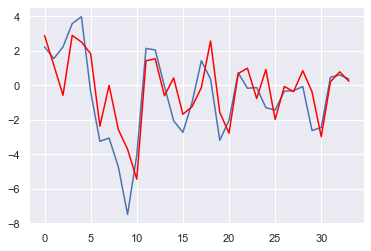

In [83]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

X = ts_diff.values
ar_train, ar_test = X[0:120], X[121:157]
# train autoregression
window = 12
model = AutoReg(ar_train, lags=12)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = ar_train[len(ar_train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(ar_test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = ar_test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
print("\nMean Absolute Error: ", mean_absolute_error(predictions, ar_test))    
print("\nRoot Mean Squared Error: ", sqrt(mean_squared_error(predictions, ar_test)))
print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(predictions, ar_test)*100, "\n")
# plot
plt.plot(ar_test)
plt.plot(predictions, color='red')
plt.show()



**Test RMSE: 1.525**

This is the Root Mean Square Error for both models. This is the error metric for this model. The closer to 0, the more accurate the models predictions are to the expected values. Judging by the actual prediction and expected values, the model is mostly accurate.

It can be concluded that without differencing, the time series is non-stationary due to it's p-values and significantly higher ADF statistic.

**MAPE: 91.719**

"ADD MORE HERE"

### Moving Average (MA) Model

Mean Absolute Error 1.985417456166786

Mean Absolute Percentage Error:  9.19588881155972 

RMSE:  17.544133777405463


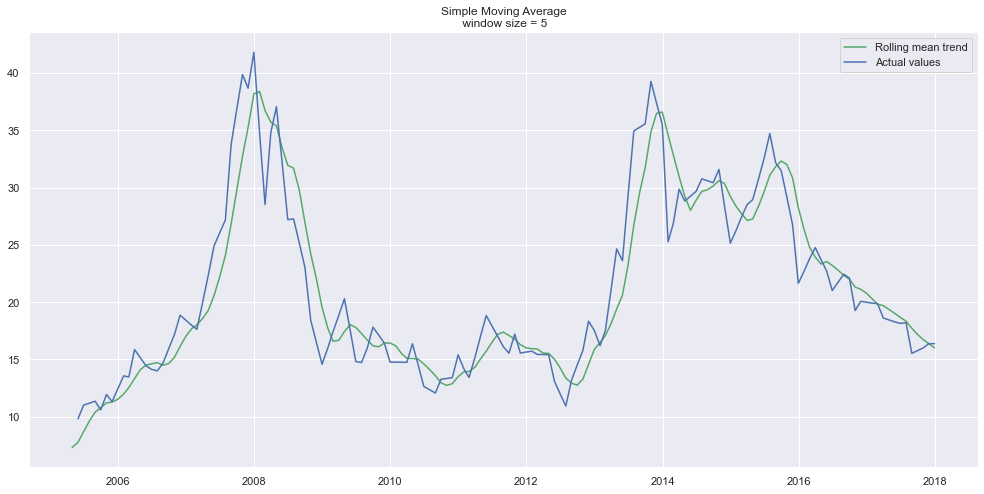

In [99]:
#SMA Taken from: https://gist.github.com/RohanTrix/b2301db8b63dcd9fe0b13a271ac4080c

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Simple Moving Average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        rmse = np.sqrt(((series - window) ** 2).mean())
        
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        #plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        #plt.plot(lower_bound, 'r--')
        #print("Mean Absolute Error: ", mae, "\n")    #uncomment to see MAE and RMSE
        #print("Root Mean Squared Error", rmse, "\n")
    print("Mean Absolute Error", mae)    
    print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(series[window:], rolling_mean[window:])*100, "\n")    
    print("RMSE: ", rmse)
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(ts, 5, plot_intervals=True)

Mean Absolute Error:  2.162594460805257

Mean Absolute Percentage Error:  122.81509883325403 

Root Mean Squared Error:  5.997388620143459


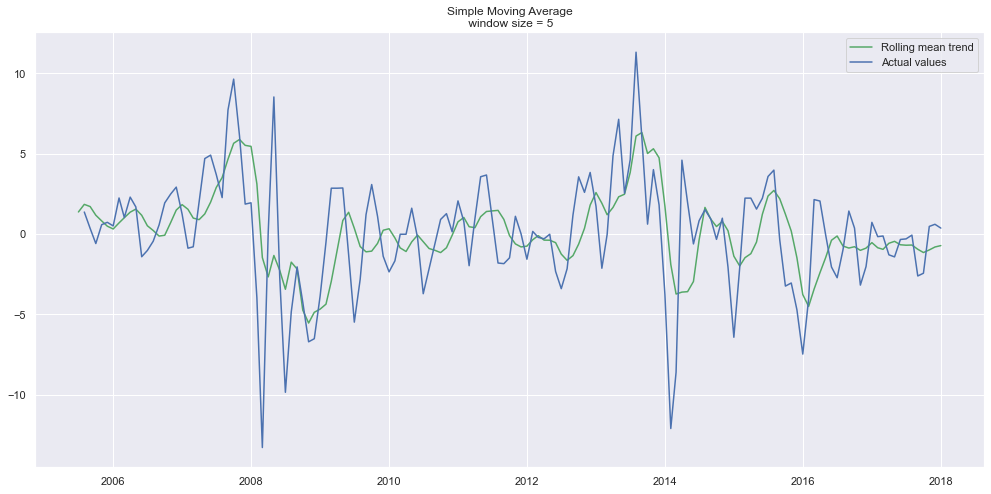

In [100]:
#SMA Taken from: https://gist.github.com/RohanTrix/b2301db8b63dcd9fe0b13a271ac4080c

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Simple Moving Average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        rmse = np.sqrt(((series - window) ** 2).mean())
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        #plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        #plt.plot(lower_bound, 'r--')
        #print("Mean Absolute Error: ", mae, "\n")    #uncomment to see MAE and RMSE
        #print("Root Mean Squared Error", rmse, "\n")
    print("Mean Absolute Error: ", mae)
    print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(series[window:], rolling_mean[window:])*100, "\n")  
    print("Root Mean Squared Error: ", rmse)    
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(ts_diff, 5, plot_intervals=True)

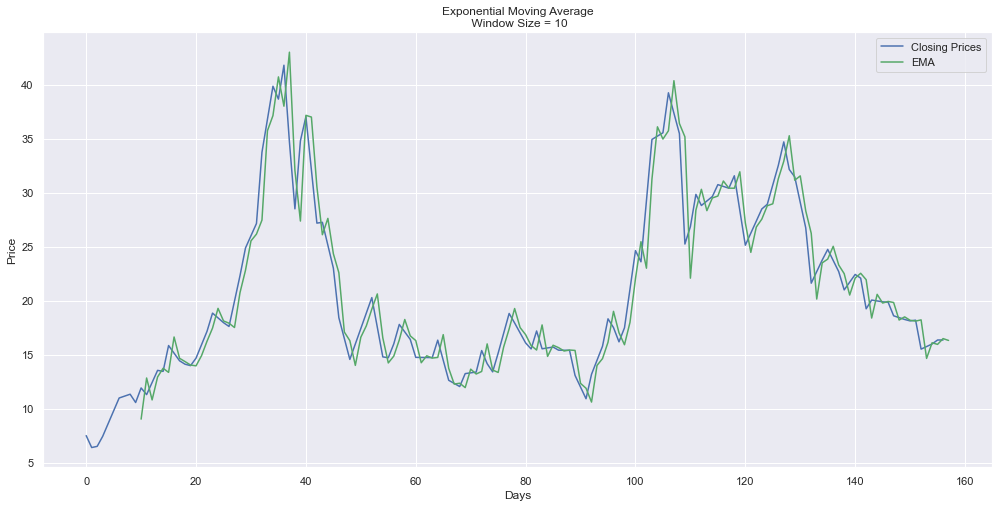

In [108]:
#Function taken from: https://gist.github.com/sohan-py/ab148e7716e1964be2fda42c132c2699#file-ema-py

def calculate_ema(prices, days, smoothing=14.5):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema


ema = calculate_ema(ts, 10)

price_X = np.arange(ts.shape[0]) # Creates array [0, 1, 2, 3, ..., df.shape[0]]
ema_X = np.arange(10, ts.shape[0]+1) # Creates array [10, 11, 12, 13, ..., df.shape[0]+1]
                                     # We start at 10, because we use the first 10 values to calculate the SMA,
                                     # then we calculate EMA form the 11th valu
plt.figure(figsize=(17,8))
plt.title('Exponential Moving Average\n Window Size = 10')        
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(price_X, ts, label='Closing Prices')
plt.plot(ema_X, ema, label='EMA', color = 'g')
plt.legend()
#print("RMSE: ", sqrt(mean_absolute_error(ema, ts))) # Unable to calculate RMSE correctly
plt.show()

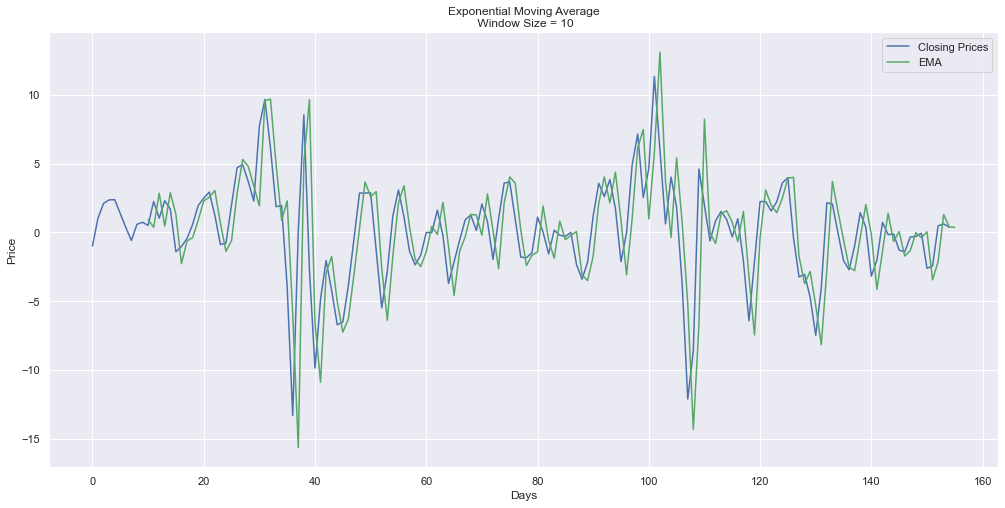

In [109]:
#Function taken from: https://gist.github.com/sohan-py/ab148e7716e1964be2fda42c132c2699#file-ema-py

def calculate_ema(prices, days, smoothing=14.5):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema


ema = calculate_ema(ts_diff, 10)

price_X = np.arange(ts_diff.shape[0]) # Creates array [0, 1, 2, 3, ..., df.shape[0]]
ema_X = np.arange(10, ts_diff.shape[0]+1) # Creates array [10, 11, 12, 13, ..., df.shape[0]+1]
                                     # We start at 10, because we use the first 10 values to calculate the SMA,
                                     # then we calculate EMA form the 11th valu
plt.figure(figsize=(17,8))
plt.title('Exponential Moving Average\n Window Size = 10')        
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(price_X, ts_diff, label='Closing Prices')
plt.plot(ema_X, ema, label='EMA', color = 'g')
plt.legend()
#print("RMSE: ", sqrt(mean_absolute_error(ema, ts))) # Unable to calculate RMSE correctly
plt.show()

The test RMSE for Simple Moving Average measures higher for non-differenced time series than the differenced time series. This suggests that differenced data is neccessary for a moving average model. Even though this is the case, the line appears to fit much better for Exponential Moving Average. For this analysis, the calculation for RMSE for Exponential Moving Average was unable to be calculated, therefore, the error metric of the model could not be calculated.



### ARIMA Model

In [88]:
import pmdarima as pm
from pmdarima.arima import auto_arima

First, the data was split into testing and training data. 80% of the data was used for training and 20% was used for testing. This was accomplished by splitting the length of the time series index first, by multiplying the length of the time series index by the size (0.8) of the training data. Then the training and testing variables were created using integer location indexing.

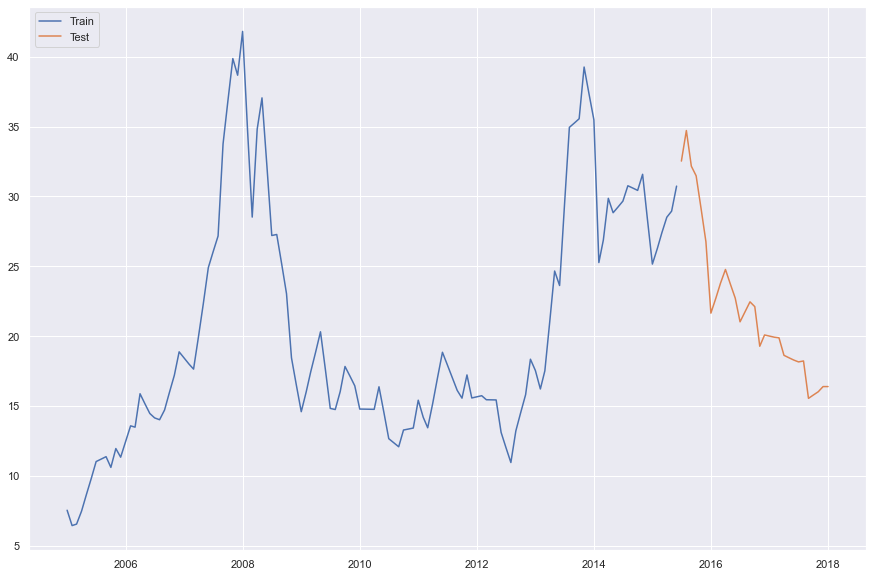

In [110]:
# Train Test Split Index
train_size = 0.8
split_idx = round(len(ts)* train_size)
split_idx

# Split
arima_train = ts.iloc[:split_idx]
arima_test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(15,10))
plt.plot(arima_train, label='Train')
plt.plot(arima_test, label='Test')
ax.legend(loc = 'upper left')

In [90]:
# Sourced from: 

arima_model = auto_arima(arima_train, start_p=0, start_q=0,
                             max_p=5, max_q=5, m=12,
                             start_P= 0, start_D = 0, start_Q= 0, 
                             seasonal=True, stationary = False,
                             d=1, D=1, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True,  
                             stepwise=False)  
arima_model.summary()


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=596.018, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=561.472, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=548.485, Time=0.16 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=592.881, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=557.598, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=543.195

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  126
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -267.598
Date:                             Thu, 24 Jun 2021   AIC                            543.195
Time:                                     15:47:32   BIC                            554.105
Sample:                                          0   HQIC                           547.622
                                             - 126                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2760      0.080      3.433      0.001       0.118       0.434
ar.S.L12      -0.7534      0.083     -9.083      0.000      -0.916      -0.591
ar.S.L24      -0.4070      0.121     -3.366      0.001      -0.644      -0.170
sigma2         6.1923      0.625      9.905      0.000       4.967       7.418
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                17.92
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.33
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For the ARIMA model, the pmdarima library was used. This library is a port of the auto.arima function from the R forecast library. It utilises a grid search method to attempt all hyperparameter combinations for comparing the best results. The best model is chosen based on the lowest AIC measurement. The model received was the SARIMAX variant of the ARIMA model which takes into account seasonality (S) and exogenous variables (X). 

#### Hyperparameters:

* Start p and q: The start p, q and d for the ARIMA component were set to 0 because it is more suitable for the grid search to iterate through all possible parameters starting from 0. 

* Start P and Q: The start P, Q and D for the seasonal component of the ARIMA model were set to 0 because it is more suitable for the grid search to iterate through all possible parameters starting from 0. 

* d and D: The differencing (integrated) component of the SARIMAX model was set to 1. There was seasonality in the dataset as seen in prior analysis using only the Autoregressive model which required differencing. When set to 0, this results in worse predictions. 

* Seasonality: Set to TRUE. The time series training data does contain seasonality so the model search has been limited to only stationary ARIMA models. Setting this to False results in inaccurate predictions. 

* Stationarity: Set to FALSE. The inputted time series training data is not stationary. Therefore, the search should include models that are non-stationary. Setting this to True results in more accuracy according to RMSE but loses the trend of the data. Using differenced values also results in worse accuracy.  

* Stepwise: Set to False. Stepwise search is less thorough than non-stepwise search. Non-stepwise search is known as parallelised search. This method brute force attempts every possible combination for the lowest AIC. 

#### Summary:

The main metrics of interest in the summary is 'P>|z|'

* P>|z| - This indicates the p-values, which we want to be as close to 0 as possible. Nearly all of them are close to zero which is a good sign for the model. 

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


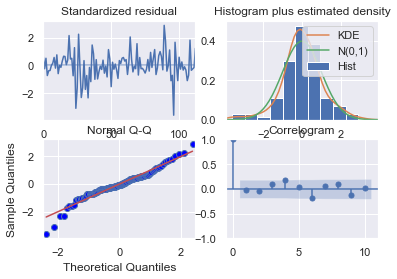

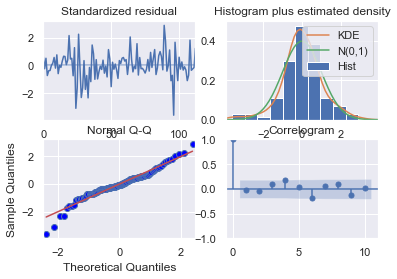

In [91]:
arima_model.plot_diagnostics()

In [92]:
# Sourced from: 

prediction = pd.DataFrame(arima_model.predict(n_periods = 31), index=arima_test.index)

prediction.columns = ['predicted_close_price']

print(prediction, "\nArima Test Data: \n", arima_test)
#print(

            predicted_close_price
date                             
2015-06-30              33.218622
2015-07-31              35.012072
2015-08-31              35.999763
2015-09-30              36.593870
2015-10-31              38.689055
2015-11-30              38.274079
2015-12-31              36.496679
2016-01-31              32.694222
2016-02-29              34.057906
2016-03-31              36.822287
2016-04-30              38.026548
2016-05-31              38.191453
2016-06-30              41.252113
2016-07-31              44.380116
2016-08-31              44.691661
2016-09-30              44.906135
2016-10-31              47.329178
2016-11-30              45.344105
2016-12-31              43.023015
2017-01-31              38.312125
2017-02-28              39.692544
2017-03-31              41.977050
2017-04-30              42.005011
2017-05-31              42.836015
2017-06-30              44.619285
2017-07-31              46.459454
2017-08-31              46.810885
2017-09-30    

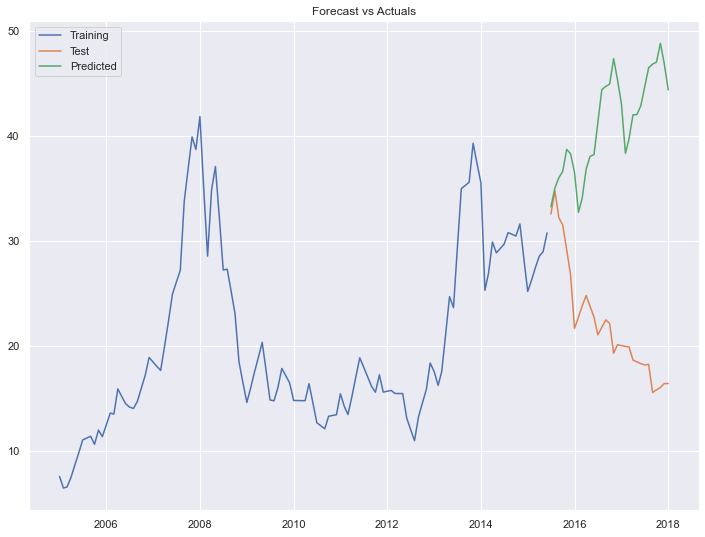

In [93]:
#forecasting with ARIMA

plt.figure(figsize=(12, 9))
plt.title("Forecast vs Actuals")
plt.plot(arima_train, label = "Training")
plt.plot(arima_test, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc = "upper left")
plt.show()

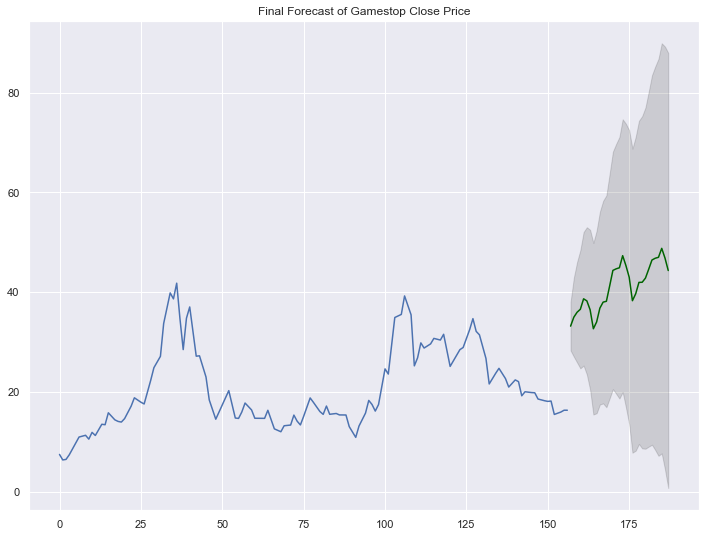

In [94]:
# Sourced from: 

# Forecast
n_periods = 31
fc, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(ts.values), len(ts.values)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12, 9))
plt.plot(ts.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Gamestop Close Price")
plt.show()

In [95]:
# Sourced from: 

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-arima_test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, arima_test.values)

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


{'mape': 0.9903353875896961,
 'me': 19.04262530623009,
 'mae': 19.04262530623009,
 'mpe': 0.9903353875896961,
 'rmse': 21.132558707599607,
 'acf1': 0.877895210444418,
 'corr': -0.7548124280733259,
 'minmax': 0.4449426938648531}

#### Prediction Values & Forecast Plot:

As shown by the prediction values and the test data values, as the time progresses, the predictions become more inaccurate. In the plot, the predicted values progress further into the incorrect direction of the test values. It appears as if the values are inverted. The test values progress lower and the prediction values progress higher. 

#### Metric Summary: 

The predictions appear to resemble the predicitions of the naive model. The predictions become less accurate as time progresses although, the results are marginally more inaccurate than the naive model. Compared to the naive model MAPE score of 0.22, the ARIMA model scored 0.27 for it's MAPE metric. Also, similar to the naive model, the time progression results in the predicitions exponentially predicting into the opposite direction although, in the ARIMA model, the magnitude of the predictions are stronger. MAE and RMSE rank fairly high which is consistent with the inaccurate results. As explained above, there are ways of tuning the parameters to get the metrics to rank lower however, much of the trend information is lost during this process and sense cannot be made from the plot, even if the direction of the prediction is closer to the one we currently have. Overall, the naive forecaster seems to be more balanced in it's predictions. 

## Machine Learning Methods for Time Series Analysis

Here, we 

In [96]:
print(y_test, y_pred)

date
2017-01-31    19.916096
2017-02-28    19.875437
2017-03-31    18.621471
2017-04-30    18.452185
2017-05-31    18.282898
2017-06-30    18.149456
2017-07-31    18.216648
2017-08-31    15.537482
2017-09-30    15.774570
2017-10-31    16.011658
2017-11-30    16.381973
2017-12-31    16.381973
Freq: M, Name: adjclose_price, dtype: float64 2017-01-31    22.713183
2017-02-28    23.785942
2017-03-31    24.768423
2017-04-30    23.741934
2017-05-31    22.715445
2017-06-30    21.019987
2017-07-31    21.735678
2017-08-31    22.451368
2017-09-30    22.107035
2017-10-31    19.270538
2017-11-30    20.078743
2017-12-31    19.997419
dtype: float64


### Gradient Boosted Trees for Time Series Forecasting

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\xgboost\data.py:121: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


>expected=19.9, predicted=20.0
>expected=19.9, predicted=20.3
>expected=18.6, predicted=20.1
>expected=18.5, predicted=18.9
>expected=18.3, predicted=18.0
>expected=18.1, predicted=18.5
>expected=18.2, predicted=18.4
>expected=15.5, predicted=18.5
>expected=15.8, predicted=15.9
>expected=16.0, predicted=17.1
>expected=16.4, predicted=16.9
>expected=16.4, predicted=15.7

Root Mean Squared Error:  1.0599923096286779

Mean Absolute Percentage Error:  4.074218531238048 

Mean Absolute Error: 0.714


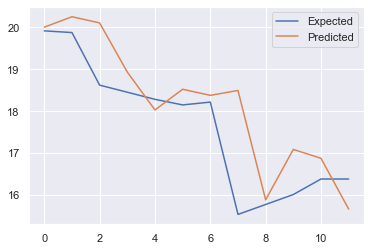

In [112]:
from xgboost import XGBRegressor
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[0]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    mse = sqrt(mean_squared_error(test[:, -1], predictions)) #Not functioning as intended
    print("\nRoot Mean Squared Error: ", mse)
    print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(test[:, -1], predictions)*100, "\n")
    return error, test[:, -1], predictions
 
# load the dataset
series = pd.read_csv('D:\Documents\gamestop.csv', header=0, index_col=0)
values = ts.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('Mean Absolute Error: %.3f' % mae)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()